**Kütüphane Import**

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
#import catboost as cat
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

**Verileri İçeri Aktarma**

In [3]:
train_df = pd.read_csv('/content/gdrive/MyDrive/ÜNİVERSİTE/Yüksek Lisans/Uğur Şevik - Projeler/DIABETIC RETINOPATHY - TUBİTAK/Veriler/train.csv',sep=',') # sep verilerin nasıl ayrıldığını belirtir.

In [4]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [5]:
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(400, 400))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = vgg_model.predict(x)
    return features.flatten()

In [6]:
train_features = np.array([extract_features("/content/gdrive/MyDrive/ÜNİVERSİTE/Yüksek Lisans/Uğur Şevik - Projeler/DIABETIC RETINOPATHY - TUBİTAK/Veriler/train_images_processed/" + img_name + ".png") for img_name in train_df["id_code"]])


1/1 [==============================] - 0s 24ms/step


**Normalizasyon ve Veri Ayırma**

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
n_train_features = scaler.fit_transform(train_features)

In [8]:
y_train = train_df["diagnosis"]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(n_train_features, y_train, test_size=0.15,shuffle=True, random_state=42)

**MODELLER**

**1-Random Forest**

In [10]:
rf = RandomForestClassifier(n_estimators=250, max_depth=8, min_samples_split=5, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_split=5, n_estimators=250)

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Eğitim ve doğrulama kümesinde tahmin yapma
train_predictions = rf.predict(X_train)
val_predictions = rf.predict(X_val)

# Eğitim ve doğrulama kümesinde metrikleri hesaplama
train_precision = precision_score(y_train, train_predictions, average='weighted')
val_precision = precision_score(y_val, val_predictions, average='weighted')

train_recall = recall_score(y_train, train_predictions, average='weighted')
val_recall = recall_score(y_val, val_predictions, average='weighted')

train_f1 = f1_score(y_train, train_predictions, average='weighted')
val_f1 = f1_score(y_val, val_predictions, average='weighted')

print("Eğitim kümesi kesinlik (precision):", train_precision)
print("Doğrulama kümesi kesinlik (precision):", val_precision)
print("Eğitim kümesi duyarlılık (recall):", train_recall)
print("Doğrulama kümesi duyarlılık (recall):", val_recall)
print("Eğitim kümesi F1-score:", train_f1)
print("Doğrulama kümesi F1-score:", val_f1)

Eğitim kümesi kesinlik (precision): 0.9095955131055597
Doğrulama kümesi kesinlik (precision): 0.7180539100508018
Eğitim kümesi duyarlılık (recall): 0.9032776349614395
Doğrulama kümesi duyarlılık (recall): 0.6927272727272727
Eğitim kümesi F1-score: 0.9041140033572691
Doğrulama kümesi F1-score: 0.6708469898692884


In [12]:
train_f1_per_class = f1_score(y_train, train_predictions, average=None)
val_f1_per_class = f1_score(y_val, val_predictions, average=None)

for i, f1_train in enumerate(train_f1_per_class):
    print("Sınıf {} için eğitim kümesi F1-score: {:.4f}".format(i, f1_train))

for i, f1_val in enumerate(val_f1_per_class):
    print("Sınıf {} için doğrulama kümesi F1-score: {:.4f}".format(i, f1_val))

Sınıf 0 için eğitim kümesi F1-score: 0.9080
Sınıf 1 için eğitim kümesi F1-score: 0.9157
Sınıf 2 için eğitim kümesi F1-score: 0.8570
Sınıf 3 için eğitim kümesi F1-score: 0.9713
Sınıf 4 için eğitim kümesi F1-score: 0.9778
Sınıf 0 için doğrulama kümesi F1-score: 0.8889
Sınıf 1 için doğrulama kümesi F1-score: 0.3182
Sınıf 2 için doğrulama kümesi F1-score: 0.6368
Sınıf 3 için doğrulama kümesi F1-score: 0.1429
Sınıf 4 için doğrulama kümesi F1-score: 0.2143


In [13]:
train_accuracy = rf.score(X_train, y_train)
val_accuracy = rf.score(X_val, y_val)
print("Eğitim kümesi doğruluğu:", train_accuracy)
print("Doğrulama kümesi doğruluğu:", val_accuracy)

Eğitim kümesi doğruluğu: 0.9032776349614395
Doğrulama kümesi doğruluğu: 0.6927272727272727


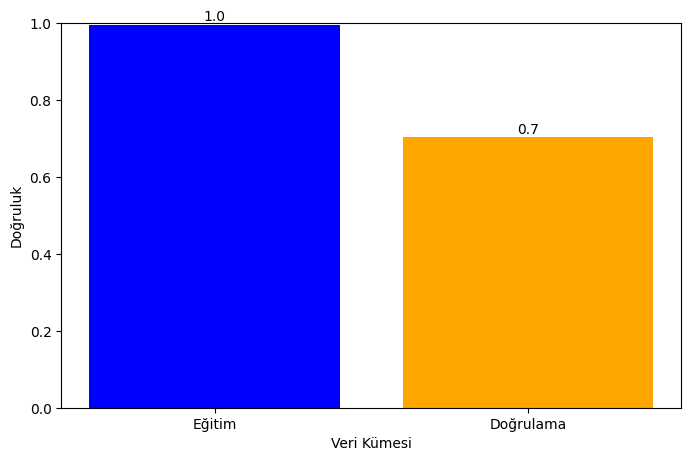

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kümesi doğruluklarını bir listede toplama
accuracies = [train_accuracy, val_accuracy]
labels = ['Eğitim', 'Doğrulama']

# Doğrulukları görselleştirme
plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.xlabel('Veri Kümesi')
plt.ylabel('Doğruluk')
plt.ylim(0, 1)  # Y eksenini 0 ile 1 arasında sınırlama (doğruluk değerleri için)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')
plt.show()

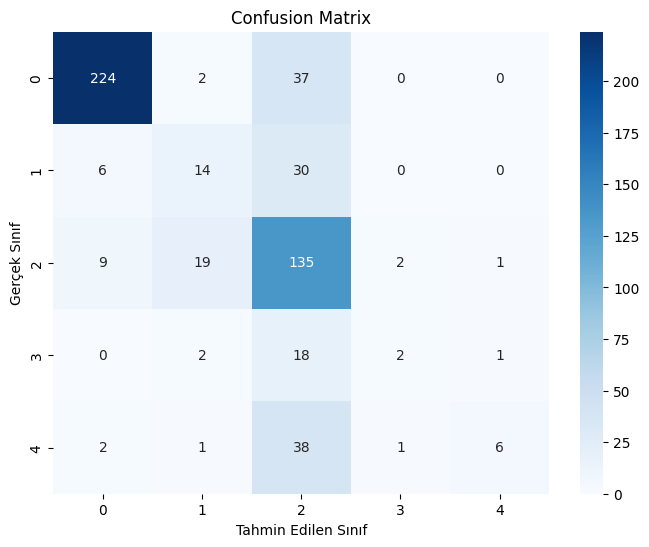

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = rf.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Confusion Matrix")
plt.show()


**2-KNN Algoritması**

In [15]:
knn = KNeighborsClassifier(n_neighbors=5,weights='distance')
knn.fit(X_train,y_train)

KNeighborsClassifier(weights='distance')

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Eğitim ve doğrulama kümesinde tahmin yapma
train_predictions = knn.predict(X_train)
val_predictions = knn.predict(X_val)

# Eğitim ve doğrulama kümesinde metrikleri hesaplama
train_precision = precision_score(y_train, train_predictions, average='weighted')
val_precision = precision_score(y_val, val_predictions, average='weighted')

train_recall = recall_score(y_train, train_predictions, average='weighted')
val_recall = recall_score(y_val, val_predictions, average='weighted')

train_f1 = f1_score(y_train, train_predictions, average='weighted')
val_f1 = f1_score(y_val, val_predictions, average='weighted')

print("Eğitim kümesi kesinlik (precision):", train_precision)
print("Doğrulama kümesi kesinlik (precision):", val_precision)
print("Eğitim kümesi duyarlılık (recall):", train_recall)
print("Doğrulama kümesi duyarlılık (recall):", val_recall)
print("Eğitim kümesi F1-score:", train_f1)
print("Doğrulama kümesi F1-score:", val_f1)

Eğitim kümesi kesinlik (precision): 0.9926272952045913
Doğrulama kümesi kesinlik (precision): 0.6092207621891166
Eğitim kümesi duyarlılık (recall): 0.9926092544987146
Doğrulama kümesi duyarlılık (recall): 0.6418181818181818
Eğitim kümesi F1-score: 0.9925878780963231
Doğrulama kümesi F1-score: 0.6223342164996075


In [17]:
train_f1_per_class = f1_score(y_train, train_predictions, average=None)
val_f1_per_class = f1_score(y_val, val_predictions, average=None)

for i, f1_train in enumerate(train_f1_per_class):
    print("Sınıf {} için eğitim kümesi F1-score: {:.4f}".format(i, f1_train))

for i, f1_val in enumerate(val_f1_per_class):
    print("Sınıf {} için doğrulama kümesi F1-score: {:.4f}".format(i, f1_val))

Sınıf 0 için eğitim kümesi F1-score: 0.9987
Sınıf 1 için eğitim kümesi F1-score: 0.9875
Sınıf 2 için eğitim kümesi F1-score: 0.9910
Sınıf 3 için eğitim kümesi F1-score: 0.9735
Sınıf 4 için eğitim kümesi F1-score: 0.9794
Sınıf 0 için doğrulama kümesi F1-score: 0.8623
Sınıf 1 için doğrulama kümesi F1-score: 0.2800
Sınıf 2 için doğrulama kümesi F1-score: 0.5494
Sınıf 3 için doğrulama kümesi F1-score: 0.0690
Sınıf 4 için doğrulama kümesi F1-score: 0.1818


In [ ]:
train_accuracy = knn.score(X_train, y_train)
val_accuracy = knn.score(X_val, y_val)
print("Eğitim kümesi doğruluğu:", train_accuracy)
print("Doğrulama kümesi doğruluğu:", val_accuracy)

Eğitim kümesi doğruluğu: 0.99522021167634
Doğrulama kümesi doğruluğu: 0.6480218281036835


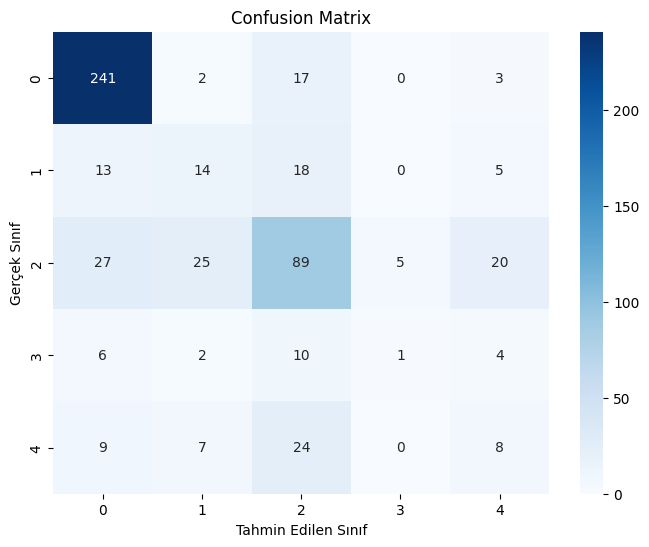

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = knn.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Confusion Matrix")
plt.show()

**3-LDA Algoritması**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=None, n_components=None)
lda.fit(X_train,y_train)

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Eğitim ve doğrulama kümesinde tahmin yapma
train_predictions = lda.predict(X_train)
val_predictions = lda.predict(X_val)

# Eğitim ve doğrulama kümesinde metrikleri hesaplama
train_precision = precision_score(y_train, train_predictions, average='weighted')
val_precision = precision_score(y_val, val_predictions, average='weighted')

train_recall = recall_score(y_train, train_predictions, average='weighted')
val_recall = recall_score(y_val, val_predictions, average='weighted')

train_f1 = f1_score(y_train, train_predictions, average='weighted')
val_f1 = f1_score(y_val, val_predictions, average='weighted')

print("Eğitim kümesi kesinlik (precision):", train_precision)
print("Doğrulama kümesi kesinlik (precision):", val_precision)
print("Eğitim kümesi duyarlılık (recall):", train_recall)
print("Doğrulama kümesi duyarlılık (recall):", val_recall)
print("Eğitim kümesi F1-score:", train_f1)
print("Doğrulama kümesi F1-score:", val_f1)

NotFittedError: This LinearDiscriminantAnalysis instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

**4-DT Algoritması**

**5-SVM Algoritması**

In [ ]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale')

In [ ]:
svm.fit(X_train, y_train)

SVC()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Eğitim ve doğrulama kümesinde tahmin yapma
train_predictions = svm.predict(X_train)
val_predictions = svm.predict(X_val)

# Eğitim ve doğrulama kümesinde metrikleri hesaplama
train_precision = precision_score(y_train, train_predictions, average='weighted')
val_precision = precision_score(y_val, val_predictions, average='weighted')

train_recall = recall_score(y_train, train_predictions, average='weighted')
val_recall = recall_score(y_val, val_predictions, average='weighted')

train_f1 = f1_score(y_train, train_predictions, average='weighted')
val_f1 = f1_score(y_val, val_predictions, average='weighted')

print("Eğitim kümesi kesinlik (precision):", train_precision)
print("Doğrulama kümesi kesinlik (precision):", val_precision)
print("Eğitim kümesi duyarlılık (recall):", train_recall)
print("Doğrulama kümesi duyarlılık (recall):", val_recall)
print("Eğitim kümesi F1-score:", train_f1)
print("Doğrulama kümesi F1-score:", val_f1)

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score
train_predictions = svm.predict(X_train)
val_predictions = svm.predict(X_val)

# Eğitim ve doğrulama kümesinde doğruluk hesaplama
train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

print("Eğitim kümesi doğruluğu:", train_accuracy)
print("Doğrulama kümesi doğruluğu:", val_accuracy)

Eğitim kümesi doğruluğu: 0.8542141230068337
Doğrulama kümesi doğruluğu: 0.7
